In [16]:
import os

import numpy as np
import polars as pl
import zarr
from tqdm import tqdm
import matplotlib.pyplot as plt

In [40]:
image_dir = "/dgx1nas1/storage/data/jess/pooled/images/cc_zarr"
prof_path = "/dgx1nas1/storage/data/jess/pooled/sc_data/processed_profiles/pilot_annotated.parquet"

In [ ]:
# CorrDNA, CorrVariantProtein_high

In [30]:
min_center = 30
max_center = 5500 - min_center

In [46]:
prof = pl.scan_parquet(prof_path)
prof = prof.select([i for i in prof.columns if "Metadata_" in i]).collect()
prof = prof.filter(pl.col("Metadata_Foci_Barcode_MatchedTo_Score_mean") >= 0.875).with_columns(
    pl.concat_str(
        [
            pl.col("Metadata_Foci_well"),
            pl.col("Metadata_Foci_site_location"),
            pl.col("Metadata_Cells_ObjectNumber"),
        ],
        separator="_",
    ).alias("Metadata_CellID")
)
high_quality_barcodes = prof.select("Metadata_CellID").to_series().to_list()

In [55]:
meta = pl.read_parquet(f"{image_dir}/cell_coords.parquet")
meta = meta.with_columns(
    pl.col("Metadata_Foci_Barcode_MatchedTo_GeneCode").str.replace(" ", "-").alias("Protein_label")
)

In [56]:
# Filter low quality barcodes
meta = meta.filter(pl.col("Metadata_CellID").is_in(high_quality_barcodes))

In [57]:
# Closeness to image edge
meta = meta.filter(
    ((pl.col("X_nuclei_int") > min_center) & (pl.col("X_nuclei_int") < max_center) &
    (pl.col("Y_nuclei_int") > min_center) & (pl.col("Y_nuclei_int") < max_center)),
)
meta = meta.with_columns(
    (pl.col("X_nuclei_int") - min_center).alias("x_low").round().cast(pl.Int16),
    (pl.col("X_nuclei_int") + min_center).alias("x_high").round().cast(pl.Int16),
    (pl.col("Y_nuclei_int") - min_center).alias("y_low").round().cast(pl.Int16),
    (pl.col("Y_nuclei_int") + min_center).alias("y_high").round().cast(pl.Int16),
)

In [58]:
# Add site ID
meta = meta.with_columns(
    pl.concat_str(["Metadata_Foci_well", "Metadata_Foci_site_location"], separator="_").alias("Metadata_SiteID")
)

meta = meta.select([
    "Metadata_CellID",
    "Protein_label",
    "Metadata_Foci_well",
    "Metadata_Foci_site_location",
    "Metadata_SiteID",
    "x_low",
    "x_high",
    "y_low",
    "y_high"
])

In [59]:
meta

Metadata_CellID,Protein_label,Metadata_Foci_well,Metadata_Foci_site_location,Metadata_SiteID,x_low,x_high,y_low,y_high
str,str,str,i64,str,i16,i16,i16,i16
"""WellB3_13_77""","""RFXANK""","""WellB3""",13,"""WellB3_13""",3552,3612,1,61
"""WellB3_13_88""","""ETHE1-L55P""","""WellB3""",13,"""WellB3_13""",3727,3787,3,63
"""WellB3_13_91""","""AMHR2-H282Q""","""WellB3""",13,"""WellB3_13""",3665,3725,7,67
"""WellB3_13_112""","""IL2RG-W237R""","""WellB3""",13,"""WellB3_13""",973,1033,16,76
"""WellB3_13_121""","""HADHB-H379R""","""WellB3""",13,"""WellB3_13""",3127,3187,15,75
"""WellB3_13_135""","""AMHR2-R54C""","""WellB3""",13,"""WellB3_13""",5225,5285,22,82
"""WellB3_13_139""","""RFXANK""","""WellB3""",13,"""WellB3_13""",3569,3629,22,82
"""WellB3_13_142""","""EBP""","""WellB3""",13,"""WellB3_13""",3102,3162,28,88
"""WellB3_13_148""","""RFXANK""","""WellB3""",13,"""WellB3_13""",2738,2798,31,91


In [34]:
img_path = f"{image_dir}/RD3_WellB5_SB505124_WellB5/CorrDNA/CorrDNA_Site_18.zarr"
img = zarr.open(img_path)

In [60]:
type(img)

zarr.core.Array

In [62]:
from skimage import exposure
import numpy as np

In [63]:
vmin = np.min(img)
vmax = np.percentile(img, 99)
img = exposure.rescale_intensity(img, in_range=(vmin, vmax), out_range=(0, 1))

In [64]:
type(img)

numpy.ndarray

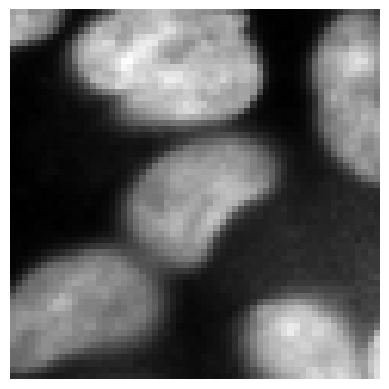

In [66]:
ind = 8
meta = meta.filter(
    (pl.col("Metadata_Foci_well") == "WellB5") &
    (pl.col("Metadata_Foci_site_location") == 18)
)
x1, x2 = meta["x_low"][ind], meta["x_high"][ind]
y1, y2 = meta["y_low"][ind], meta["y_high"][ind]
crop = img[y1:y2, x1:x2]

plt.imshow(crop, cmap="grey")
plt.axis('off')  # Turn off axis labels
plt.show()